In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
from tensorflow.keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

2024-05-02 11:30:37.977120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 11:30:37.977239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 11:30:38.172252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


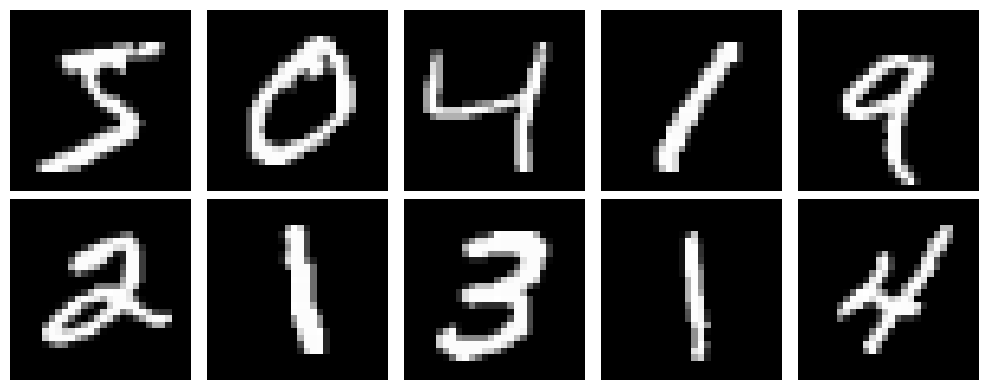

In [2]:
def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(x_train)

In [3]:

# plot_samples(x_train[50000])
x_train[50000].shape

(28, 28)

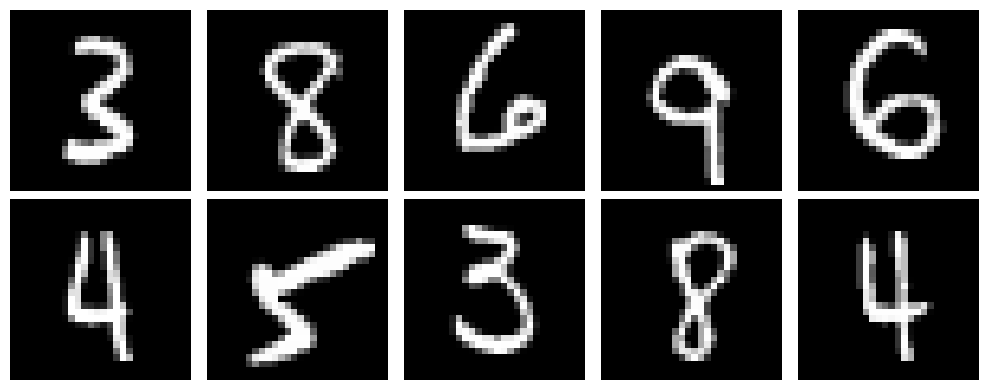

In [4]:
plot_samples(x_train[50000:50010])

In [5]:
X_train = x_train.astype("float32")/255
X_test = x_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

## Train|val|test split

In [6]:
from sklearn.model_selection import train_test_split

# we already have X_train: 60000 samples 
# X_train_val: 50000 samples -> training part for validation and hyperparameter tuning
# X_val: 10000 samples -> validation used for hyperparameter tuning and validation loss curves
# train on train_val and validate on val to hyperparameter tune, then when finished train on whole training data set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1 / 6, random_state=42
)

# rank 3 
X_train_val.shape, X_val.shape

((50000, 28, 28), (10000, 28, 28))

In [7]:
# we will use ImageDataGenerator to augment our data
# it requires rank 4 e.g. (50000,28,28,3), (10000,28,28,1)
X_train_val[..., None].shape


(50000, 28, 28, 1)

In [8]:
X_train_val = X_train_val[..., None]
X_train = X_train[..., None]
X_val = X_val[..., None]
X_test = X_test[..., None]

X_train_val.shape


(50000, 28, 28, 1)

## Data augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

help(ImageDataGenerator())

Help on ImageDataGenerator in module keras.src.legacy.preprocessing.image object:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  DEPRECATED.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom

In [10]:
train_image_generator = ImageDataGenerator(rotation_range=90)

# batch size 32 - used for mini-batch gradient descent - which gives us stochasticity in backpropagation
# flow is used for regenerating images after it has been exhausted 
# this is because we will train in many epochs 
train_generator = train_image_generator.flow(X_train, y_train, batch_size=32) 

train_generator

In [11]:
# 32 gray scaled images - this is first batch
train_generator[0][0].shape

(32, 28, 28, 1)

In [12]:
train_generator[1][0].shape # 2nd batch

(32, 28, 28, 1)

In [13]:
train_generator[1][1].shape # labels for 2nd batch

(32,)

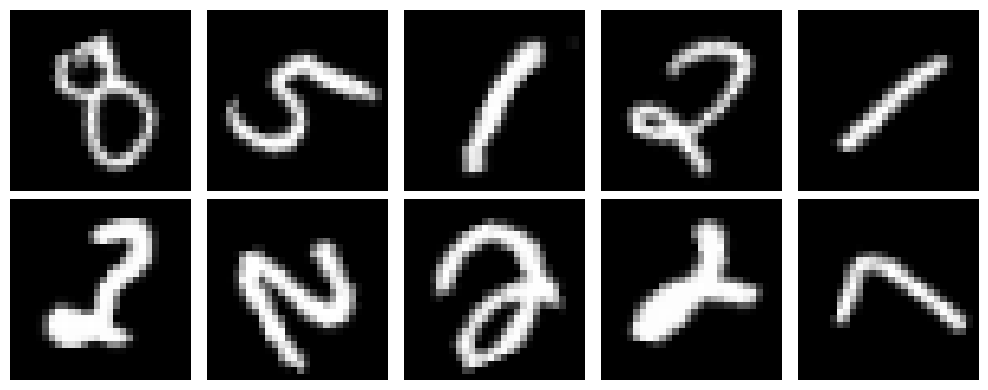

In [14]:
# illustrates what happens with up to 90° rotation
plot_samples(next(train_generator)[0])

## Make a good augmenatation

In [15]:
train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.1,
    width_shift_range=0.2,
)

# don't augment test data and validation data - want to test on original data
# this is used for mini-batch in training
test_image_generator = ImageDataGenerator()

train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)
train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size=32)
val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

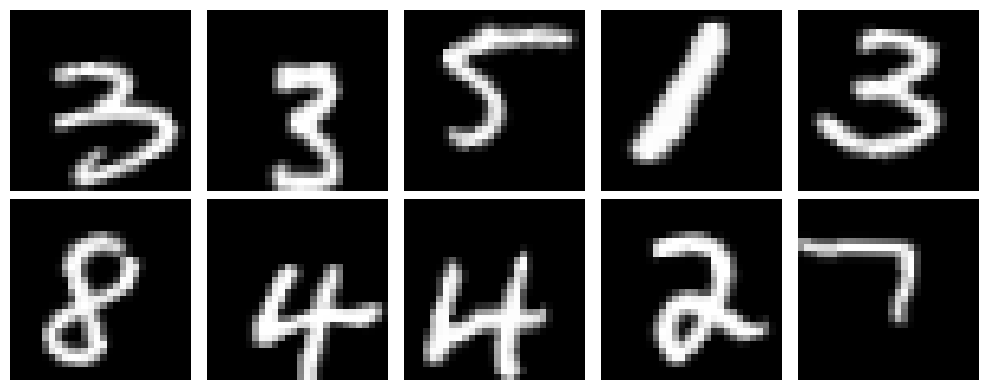

In [16]:
plot_samples(next(train_generator)[0])

## CNN model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def cnn_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    # MLP part
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = cnn_model(drop_rate=.5)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

## Train on augmented data

In [18]:
# number of steps for minibatch in one epoch 
steps_per_epoch = len(X_train_val)//32
validation_steps = len(X_val)//32

# number of batches to be ran in one epoch
steps_per_epoch, validation_steps

(1562, 312)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=[early_stopper],
    validation_data = val_generator, # this will give us batches for validation
    validation_steps = validation_steps
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  14/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - acc: 0.1075 - loss: 2.7271

I0000 00:00:1714649459.998478     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714649460.017072     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 889/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - acc: 0.6266 - loss: 1.1063

W0000 00:00:1714649473.495336     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1554/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7028 - loss: 0.8871

W0000 00:00:1714649482.713935     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - acc: 0.7035 - loss: 0.8850 - val_acc: 0.9686 - val_loss: 0.1014
Epoch 2/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9375 - loss: 0.1595

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - acc: 0.9375 - loss: 0.1595 - val_acc: 0.9375 - val_loss: 0.0906
Epoch 3/50
   6/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9439 - loss: 0.1888  

W0000 00:00:1714649483.983314     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - acc: 0.9233 - loss: 0.2401 - val_acc: 0.9715 - val_loss: 0.0868
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - acc: 0.9688 - loss: 0.2000 - val_acc: 1.0000 - val_loss: 0.0224
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - acc: 0.9448 - loss: 0.1740 - val_acc: 0.9835 - val_loss: 0.0495
Epoch 6/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - acc: 1.0000 - loss: 0.0255 - val_acc: 1.0000 - val_loss: 5.3933e-04
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9521 - loss: 0.1541 - val_acc: 0.9839 - val_loss: 0.0535
Epoch 8/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - acc: 0.9688 - loss: 0.0512 - val_acc: 1.0000 - val_loss: 0.0055
Epoch 9/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9583 - loss: 0.1324 - val_acc: 0.9884 - val_loss: 0.0357


In [20]:
metrics = pd.DataFrame(model.history.history)
metrics

,acc,loss,val_acc,val_loss
0,0.828510,0.524394,0.968650,0.101386
1,0.937500,0.159471,0.937500,0.090582
2,0.930155,0.219547,0.971454,0.086837
3,0.968750,0.200001,1.000000,0.022446
4,0.947106,0.167246,0.983474,0.049492
5,1.000000,0.025531,1.000000,0.000539
6,0.954211,0.147265,0.983874,0.053473
7,0.968750,0.051173,1.000000,0.005498
8,0.957853,0.134788,0.988381,0.035721


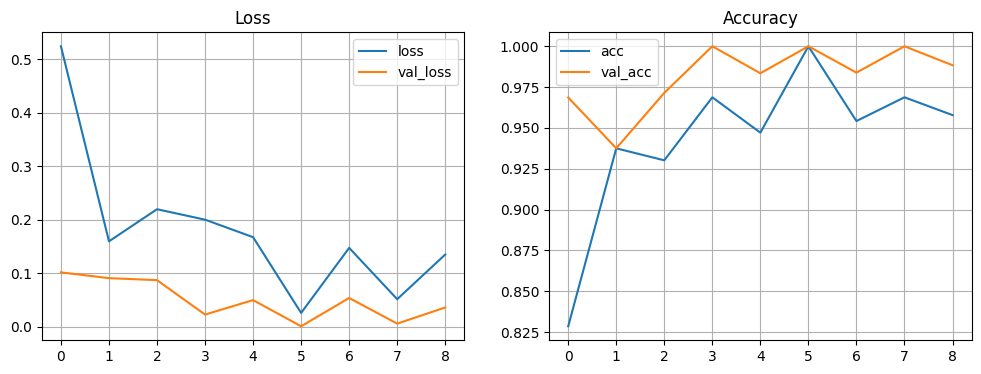

In [21]:

def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

# harder to overfit
plot_metrics(metrics)

In [22]:
model = cnn_model()
# can recalculate steps_per_epoch to be 60000/32 instead of 50000/32
model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=10)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  15/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - acc: 0.1422 - loss: 2.5007

W0000 00:00:1714649569.934994     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - acc: 0.7146 - loss: 0.8523
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9303 - loss: 0.2191  
Epoch 3/10
   5/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - acc: 0.9647 - loss: 0.1488 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9350 - loss: 0.2040
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9549 - loss: 0.1490  
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9484 - loss: 0.1618
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9600 - loss: 0.1276  
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - acc: 0.9577 - loss: 0.1374
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9610 - loss: 0.1282  
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - acc: 0.9625 - loss: 0.1164
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9648 - loss: 0.1141  


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred

115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1714649686.771142     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1714649687.466884     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[1.3204382e-08, 6.3554472e-07, 6.3413652e-05, ..., 9.9993348e-01,
        1.7734402e-07, 2.0215591e-06],
       [6.6954402e-07, 4.6967827e-08, 9.9999917e-01, ..., 7.8168333e-11,
        3.6524202e-08, 3.9657170e-11],
       [1.6336548e-05, 9.9961710e-01, 2.7852946e-07, ..., 2.1908897e-06,
        2.3279292e-05, 1.5231607e-05],
       ...,
       [1.1422593e-10, 9.1180778e-11, 1.2249799e-09, ..., 1.8577948e-09,
        7.1713302e-08, 1.3249556e-06],
       [1.2141079e-06, 5.1872572e-11, 2.3418001e-09, ..., 6.8563516e-08,
        2.4787023e-05, 6.0788389e-05],
       [6.4847212e-05, 1.1810201e-08, 8.5283062e-07, ..., 1.1464144e-08,
        4.4112824e-04, 1.2251598e-04]], dtype=float32)

In [24]:
y_pred[0], y_test[0]

(array([1.3204382e-08, 6.3554472e-07, 6.3413652e-05, 2.1777501e-07,
        3.0300978e-08, 1.1146634e-09, 2.4164322e-11, 9.9993348e-01,
        1.7734402e-07, 2.0215591e-06], dtype=float32),
 7)

In [25]:
y_pred[50], y_test[50]

(array([4.5021825e-06, 5.6476401e-09, 8.3743572e-08, 2.4521316e-09,
        2.8129696e-06, 1.2616169e-06, 9.9996674e-01, 2.4090183e-09,
        7.1432742e-06, 1.7414175e-05], dtype=float32),
 6)

In [26]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



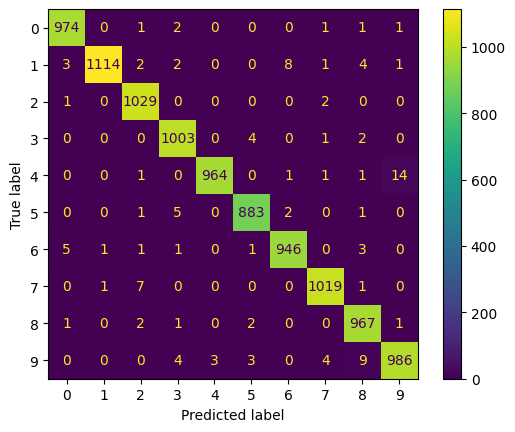

In [28]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()